In [1]:
import os
from sklearn.model_selection import train_test_split
from helper import * 
from unet import UNet
import torch
from torch import optim

TRAIN_RATIO = 0.8
RS = 30448
N_CHANNELS, N_CLASSES = 1, 1 
bilinear = True
BATCH_SIZE, EPOCHS = 16, 500
IMAGE_SIZE = (600, 600)
CROP_SIZE = (600, 600)
device = torch.device('cuda:0')
LR, WD, TH = 1e-3, 1e-4, 0.9
best_avg_acc, best_epoch = 0.0, 0
CLIENTS = ['miccai', 'bns', 'monuseg', 'tnbc', 'monusac']
CLIENTS_2 = [cl + '_2' for cl in CLIENTS]
###################################################################
TOTAL_CLIENTS = len(CLIENTS)

DIR_DATA = 'data/imagesTrAug/'
DIR_GT = 'data/labelsTrBW/'

# Costruire una lista dei nomi dei file per ciascun nuovo dataset.
skin_dataset = dict()
skin_dataset['miccai'] = ['miccai_{:03d}'.format(i) for i in range(201, 227)]  # Nomi dei file per il dataset "miccai"
skin_dataset['bns'] = ['bns_{:03d}'.format(i) for i in range(181, 204)]  # Nomi dei file per il dataset "bns"
skin_dataset['monuseg'] = ['monu_{:03d}'.format(i) for i in range(1, 52)]  # Nomi dei file per il dataset "monu"
skin_dataset['tnbc'] = ['tnbc_{:03d}'.format(i) for i in range(1, 52)]  # Nomi dei file per il dataset "tnbc"
skin_dataset['monusac'] = ['monusac_{:03d}'.format(i) for i in range(1, 44)]  # Nomi dei file per il dataset "monusac"
split_dataset = dict()
STATIC_WEIGHT = [0, 0, 0, 0, 0]
order = 0

from sklearn.model_selection import train_test_split

for client in skin_dataset:
    tmp = skin_dataset[client]
    x_ = [os.path.join(DIR_DATA, f + '.png') for f in tmp]
    y_ = [os.path.join(DIR_GT, f + '.png') for f in tmp]
    
    # Dividi il dataset in train (80%) e temp (20% per val e test)
    x_train, x_temp, y_train, y_temp = train_test_split(
        x_, y_, test_size=0.2, random_state=RS)  # 20% per val e test

    # Ora suddividi temp in val e test, mantenendo lo stesso numero di immagini
    x_val, x_test, y_val, y_test = train_test_split(
        x_temp, y_temp, test_size=0.5, random_state=RS)  # 50% di 20% per val e test

    split_dataset[client + '_train'] = Cancer(x_train, y_train, train=True, 
                                              IMAGE_SIZE=IMAGE_SIZE, 
                                              CROP_SIZE=CROP_SIZE)
    STATIC_WEIGHT[order] = len(x_train)
    order += 1

    split_dataset[client + '_val'] = Cancer(x_val, y_val, train=False, 
                                             IMAGE_SIZE=IMAGE_SIZE, 
                                             CROP_SIZE=CROP_SIZE)

    split_dataset[client + '_test'] = Cancer(x_test, y_test, train=False, 
                                             IMAGE_SIZE=IMAGE_SIZE, 
                                             CROP_SIZE=CROP_SIZE)
    print(client)



# Aggiungi le immagini rimanenti di Miccai al set di addestramento di Miccai
miccai_remaining = ['miccai_{:03d}'.format(i) for i in range(1, 201)]  # Immagini non ancora aggiunte
miccai_train = split_dataset['miccai_train'].data  # Percorsi delle immagini già nel set di addestramento di Miccai
miccai_remaining = [os.path.join(DIR_DATA, f + '.png') for f in miccai_remaining if f not in miccai_train]
split_dataset['miccai_train'].data.extend(miccai_remaining)

# Aggiungi le immagini rimanenti di Bns al set di addestramento di Bns
bns_remaining = ['bns_{:03d}'.format(i) for i in range(1, 181)]  # Immagini non ancora aggiunte
bns_train = split_dataset['bns_train'].data  # Percorsi delle immagini già nel set di addestramento di Bns
bns_remaining = [os.path.join(DIR_DATA, f + '.png') for f in bns_remaining if f not in bns_train]
split_dataset['bns_train'].data.extend(bns_remaining)

# Aggiungi le immagini rimanenti di Bns al set di addestramento di MoNu
monu_remaining = ['monu_{:03d}'.format(i) for i in range(52, 155)]  # Immagini non ancora aggiunte
monu_train = split_dataset['monuseg_train'].data  # Percorsi delle immagini già nel set di addestramento di MoNu
monu_remaining = [os.path.join(DIR_DATA, f + '.png') for f in monu_remaining if f not in monu_train]
split_dataset['monuseg_train'].data.extend(monu_remaining)

# Aggiungi le immagini rimanenti di Bns al set di addestramento di MoNu
tnbc_remaining = ['tnbc_{:03d}'.format(i) for i in range(52, 145)]  # Immagini non ancora aggiunte
tnbc_train = split_dataset['tnbc_train'].data  # Percorsi delle immagini già nel set di addestramento di MoNu
tnbc_remaining = [os.path.join(DIR_DATA, f + '.png') for f in tnbc_remaining if f not in tnbc_train]
split_dataset['tnbc_train'].data.extend(tnbc_remaining)

# Aggiungi le immagini rimanenti di Bns al set di addestramento di MoNu
monusac_remaining = ['monusac_{:03d}'.format(i) for i in range(44, 202)]  # Immagini non ancora aggiunte
monusac_train = split_dataset['monusac_train'].data  # Percorsi delle immagini già nel set di addestramento di MoNu
monusac_remaining = [os.path.join(DIR_DATA, f + '.png') for f in monusac_remaining if f not in monusac_train]
split_dataset['monusac_train'].data.extend(monu_remaining)

training_clients, testing_clients, true_testing_clients = dict(), dict(), dict()
training_clients_pl = dict()

acc_train, acc_test, loss_train, loss_test = dict(), dict(), \
                                            dict(), dict()
    
nets, optimizers = dict(), dict()

nets['global'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)

nets['global_2'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)

for client in CLIENTS:
    print(client)
    training_clients[client] = DataLoader(split_dataset[client+'_train'], batch_size=4,\
                 shuffle=True, num_workers=8)
    training_clients_pl[client] = DataLoader(split_dataset[client+'_train'], batch_size=1, \
                shuffle=True, num_workers=8)
    ###################################################################################
    testing_clients[client] = DataLoader(split_dataset[client+'_test'], batch_size=1,\
                         shuffle=False, num_workers=1)
    true_testing_clients[client] = DataLoader(split_dataset[client+'_val'], batch_size=1,\
                         shuffle=False, num_workers=1)
    acc_train[client], acc_test[client] = [], []
    loss_train[client], loss_test[client] = [], []
        
    nets[client] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)
    nets[client+'_2'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)
    optimizers[client]= optim.Adam(nets[client].parameters(), \
                                   lr=LR,weight_decay=WD)
    optimizers[client+'_2']= optim.Adam(nets[client+'_2'].parameters(), \
                                   lr=LR,weight_decay=WD)

miccai
bns
monuseg
tnbc
monusac
miccai
bns
monuseg
tnbc
monusac


In [2]:
import numpy as np

def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

TypeError: Invalid shape (1, 600, 600) for image data

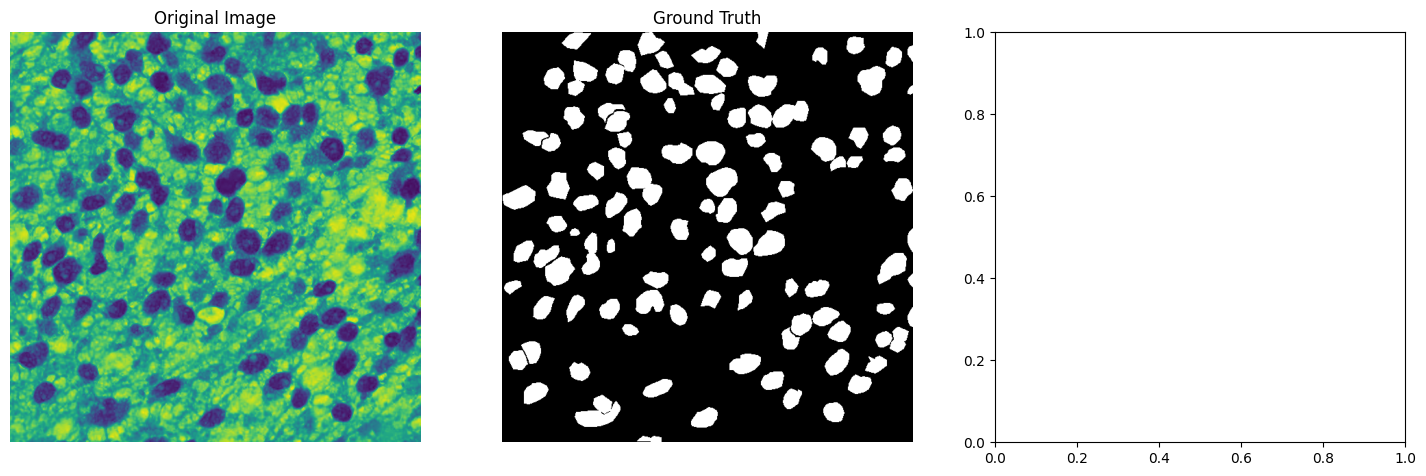

In [6]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

def test_ultimate(epoch, testloader, net, device, acc=None, loss=None):
    net.eval()
    t_loss, t_acc = 0, 0
    t_precision, t_recall, t_accuracy, t_dice, t_iou = 0, 0, 0, 0, 0
    num_samples = len(testloader.dataset)

    tp_total, tn_total, fp_total, fn_total = 0, 0, 0, 0
    
    with torch.no_grad():
        for (imgs, masks, _) in testloader:
            masks = masks.type(torch.float32)
            imgs, masks = imgs.to(device), masks.to(device)
            
            masks_pred = net(imgs)
            masks_pred = torch.sigmoid(masks_pred)
            l_ = 1 - dice_coeff(masks_pred, masks.type(torch.float))
            t_loss += l_.item()
            
            masks_pred = (masks_pred > 0.5).float()
            
            for i in range(imgs.size(0)):
                pred_mask = masks_pred[i].squeeze().cpu().numpy()
                gt_mask = masks[i].squeeze().cpu().numpy()
                t_precision += precision_score_(gt_mask, pred_mask)
                t_recall += recall_score_(gt_mask, pred_mask)
                t_accuracy += accuracy(gt_mask, pred_mask)
                t_dice += dice_coef(gt_mask, pred_mask)
                t_iou += iou(gt_mask, pred_mask)
                
                # Calculate TP, TN, FP, FN
                tp = np.sum((pred_mask == 1) & (gt_mask == 1))
                tn = np.sum((pred_mask == 0) & (gt_mask == 0))
                fp = np.sum((pred_mask == 1) & (gt_mask == 0))
                fn = np.sum((pred_mask == 0) & (gt_mask == 1))

                tp_total += tp
                tn_total += tn
                fp_total += fp
                fn_total += fn
            
            # Plotting the original image, ground truth, and predicted mask
            for i in range(imgs.size(0)):
                plt.figure(figsize=(18, 6))

                plt.subplot(1, 3, 1)
                plt.imshow(imgs[i].permute(1, 2, 0).cpu().numpy())
                plt.title('Original Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(masks[i].squeeze(0).cpu().numpy(), cmap='gray')
                plt.title('Ground Truth')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(masks_pred[i].squeeze(0).cpu().numpy(), cmap='gray')
                plt.title('Segmentation Prediction')
                plt.axis('off')

                plt.show()

    t_loss /= len(testloader)
    t_precision /= num_samples
    t_recall /= num_samples
    t_accuracy /= num_samples
    t_dice /= num_samples
    t_iou /= num_samples

    print(f"Accuracy: {round(t_accuracy, 3)}")
    print(f"Precision: {round(t_precision, 3)}")
    print(f"Recall: {round(t_recall, 3)}")
    print(f"Test Loss: {round(t_loss, 3)}")
    print(f"Dice Coef: {round(t_dice, 3)}")
    print(f"Jaccard Index: {round(t_iou, 3)}")
    
    print(f"True Positives (TP): {tp_total}")
    print(f"True Negatives (TN): {tn_total}")
    print(f"False Positives (FP): {fp_total}")
    print(f"False Negatives (FN): {fn_total}")

    if acc is not None:
        acc.append(t_accuracy)
    if loss is not None:
        loss.append(t_loss)
   
    del t_acc, t_loss

model_path = r"./best_fed_model.pt"
testing_loader = true_testing_clients['miccai']
net = nets['global']

net.load_state_dict(torch.load(model_path))

test_ultimate(0, testing_loader, net, device)


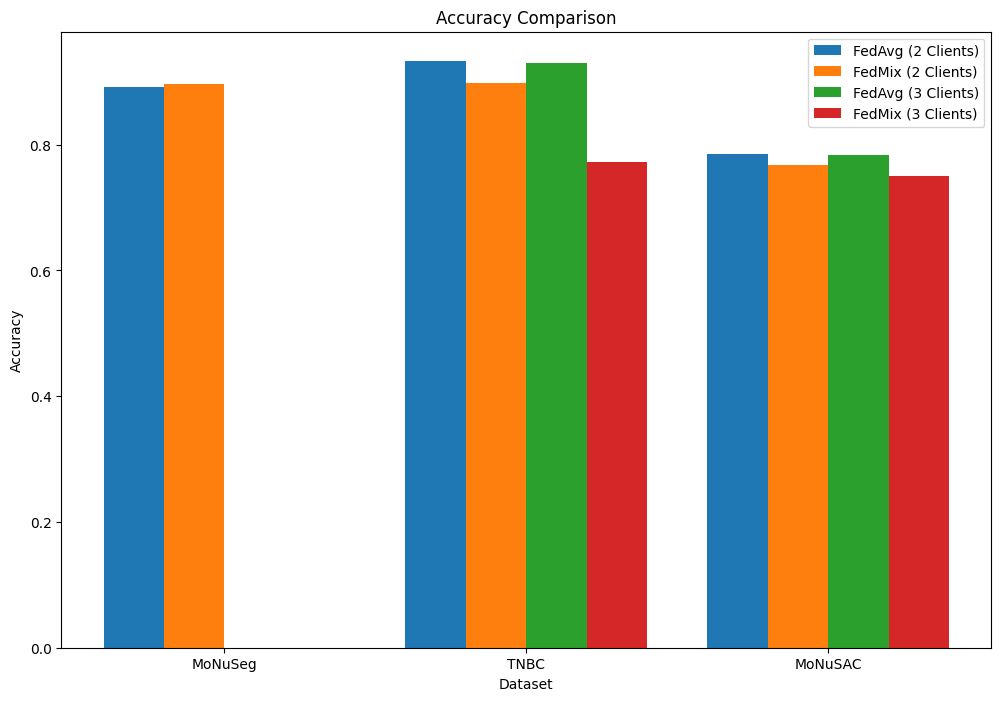

In [5]:
import matplotlib.pyplot as plt

# Imposta le dimensioni della figura
plt.figure(figsize=(12, 8))

# Dati per FedAvg
fedavg_2_clients = {
    "MoNuSeg": 0.892,
    "TNBC": 0.933,
    "MoNuSAC": 0.785
}

fedavg_3_clients = {
    "TNBC": 0.93,
    "MoNuSAC": 0.783
}

# Dati per FedMix
fedmix_2_clients = {
    "MoNuSeg": 0.896,
    "TNBC": 0.898,
    "MoNuSAC": 0.767
}

fedmix_3_clients = {
    "TNBC": 0.772,
    "MoNuSAC": 0.75
}

# Creazione degli istogrammi
datasets = ["MoNuSeg", "TNBC", "MoNuSAC"]
labels = ["FedAvg (2 Clients)", "FedMix (2 Clients)", "FedAvg (3 Clients)", "FedMix (3 Clients)"]
fedavg_2 = [fedavg_2_clients.get(dataset, 0) for dataset in datasets]
fedmix_2 = [fedmix_2_clients.get(dataset, 0) for dataset in datasets]
fedavg_3 = [fedavg_3_clients.get(dataset, 0) for dataset in datasets]
fedmix_3 = [fedmix_3_clients.get(dataset, 0) for dataset in datasets]

x = range(len(datasets))
width = 0.2

plt.bar(x, fedavg_2, width, label="FedAvg (2 Clients)")
plt.bar([i + width for i in x], fedmix_2, width, label="FedMix (2 Clients)")
plt.bar([i + 2 * width for i in x], fedavg_3, width, label="FedAvg (3 Clients)")
plt.bar([i + 3 * width for i in x], fedmix_3, width, label="FedMix (3 Clients)")

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks([i + 1.5 * width for i in x], datasets)
plt.legend()

plt.show()


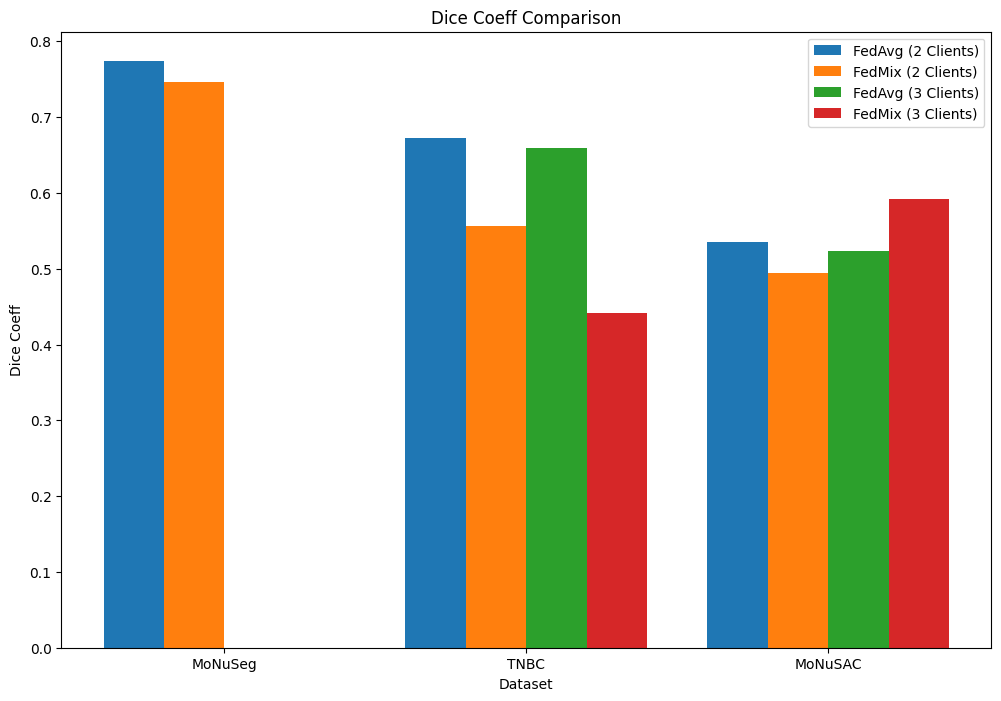

In [7]:
import matplotlib.pyplot as plt

# Imposta le dimensioni della figura
plt.figure(figsize=(12, 8))

# Dati per FedAvg
fedavg_2_clients = {
    "MoNuSeg": 0.774,
    "TNBC": 0.673,
    "MoNuSAC": 0.535
}

fedavg_3_clients = {
    "TNBC": 0.659,
    "MoNuSAC": 0.524
}

# Dati per FedMix
fedmix_2_clients = {
    "MoNuSeg": 0.747,
    "TNBC": 0.557,
    "MoNuSAC": 0.494
}

fedmix_3_clients = {
    "TNBC": 0.442,
    "MoNuSAC": 0.592
}

# Creazione degli istogrammi
datasets = ["MoNuSeg", "TNBC", "MoNuSAC"]
labels = ["FedAvg (2 Clients)", "FedMix (2 Clients)", "FedAvg (3 Clients)", "FedMix (3 Clients)"]
fedavg_2 = [fedavg_2_clients.get(dataset, 0) for dataset in datasets]
fedmix_2 = [fedmix_2_clients.get(dataset, 0) for dataset in datasets]
fedavg_3 = [fedavg_3_clients.get(dataset, 0) for dataset in datasets]
fedmix_3 = [fedmix_3_clients.get(dataset, 0) for dataset in datasets]

x = range(len(datasets))
width = 0.2

plt.bar(x, fedavg_2, width, label="FedAvg (2 Clients)")
plt.bar([i + width for i in x], fedmix_2, width, label="FedMix (2 Clients)")
plt.bar([i + 2 * width for i in x], fedavg_3, width, label="FedAvg (3 Clients)")
plt.bar([i + 3 * width for i in x], fedmix_3, width, label="FedMix (3 Clients)")

plt.xlabel('Dataset')
plt.ylabel('Dice Coeff')
plt.title('Dice Coeff Comparison')
plt.xticks([i + 1.5 * width for i in x], datasets)
plt.legend()

plt.show()
